# **Import Packages**

In [ ]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.3 MB/s 


In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes


In [ ]:
!kaggle datasets download -d adityamahimkar/iqothnccd-lung-cancer-dataset

 98% 194M/199M [00:04<00:00, 59.4MB/s]
100% 199M/199M [00:04<00:00, 43.4MB/s]


In [ ]:
from zipfile import ZipFile
file_name = "/content/iqothnccd-lung-cancer-dataset.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import seaborn as sns
import cv2
import random
import os
import imageio
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, RepeatedStratifiedKFold
from imblearn.over_sampling import SMOTE

import tensorflow as tf
import tensorflow_addons as tfa
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.applications import resnet
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
from keras.applications.resnet import ResNet50
from keras_preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

In [ ]:
directory = r'../content/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset'

categories = ['Bengin cases', 'Malignant cases', 'Normal cases']

# **Image Size Variations**

In [ ]:
size_data = {}
for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    temp_dict = {}
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        height, width, channels = imageio.imread(filepath).shape
        if str(height) + ' x ' + str(width) in temp_dict:
            temp_dict[str(height) + ' x ' + str(width)] += 1
        else:
            temp_dict[str(height) + ' x ' + str(width)] = 1

    size_data[i] = temp_dict

size_data

{'Bengin cases': {'512 x 512': 120},
 'Malignant cases': {'512 x 512': 501,
  '512 x 801': 28,
  '512 x 623': 31,
  '404 x 511': 1},
 'Normal cases': {'512 x 512': 415, '331 x 506': 1}}

Bengin cases


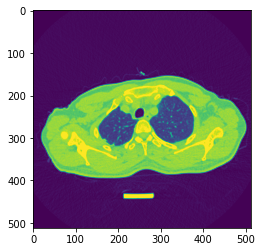

Malignant cases


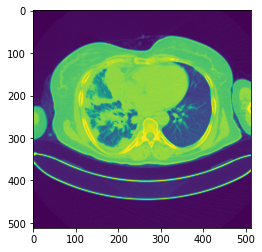

Normal cases


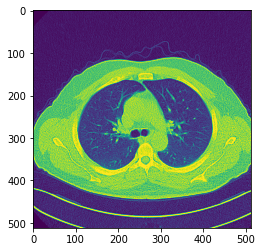

In [ ]:
for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        print(i)
        img = cv2.imread(filepath, 0)
        plt.imshow(img)
        plt.show()
        break

# **Image Preprocessing and Testing**

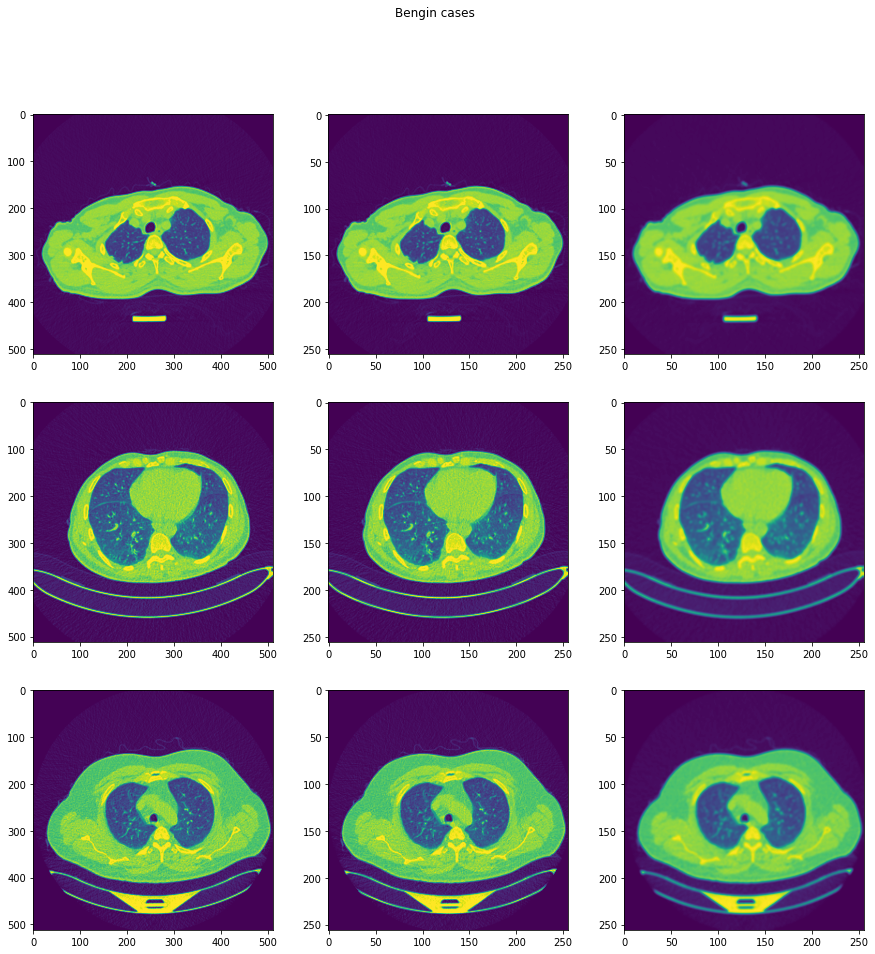

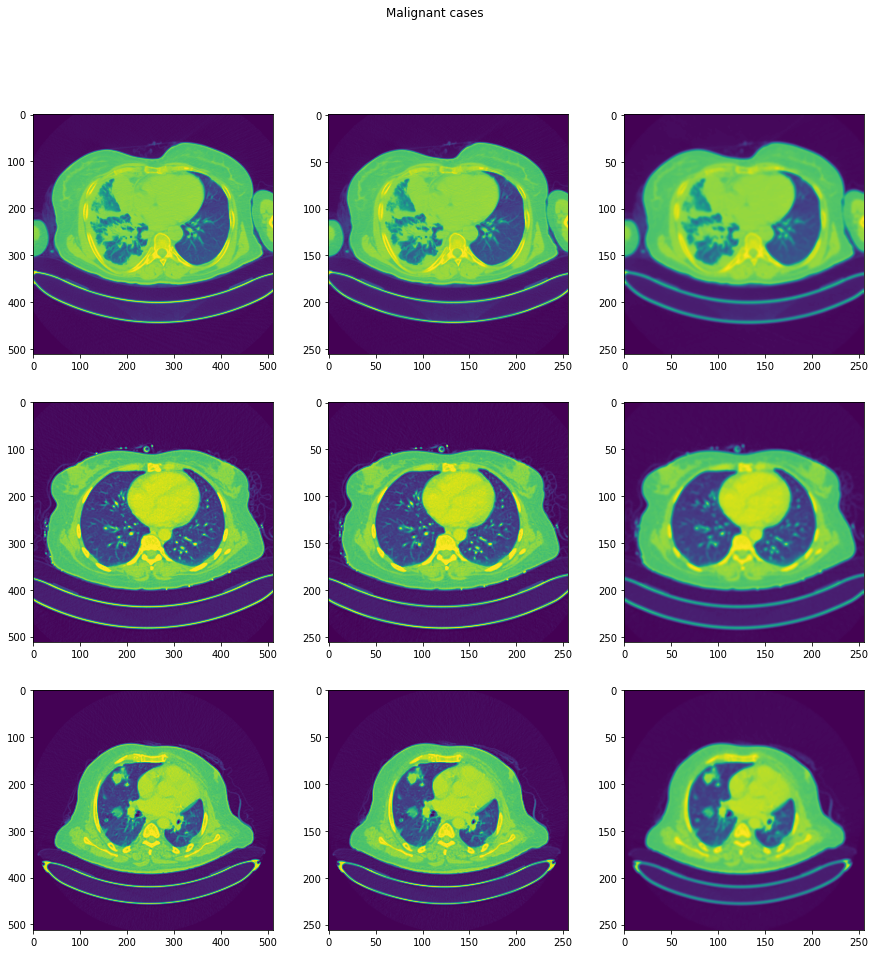

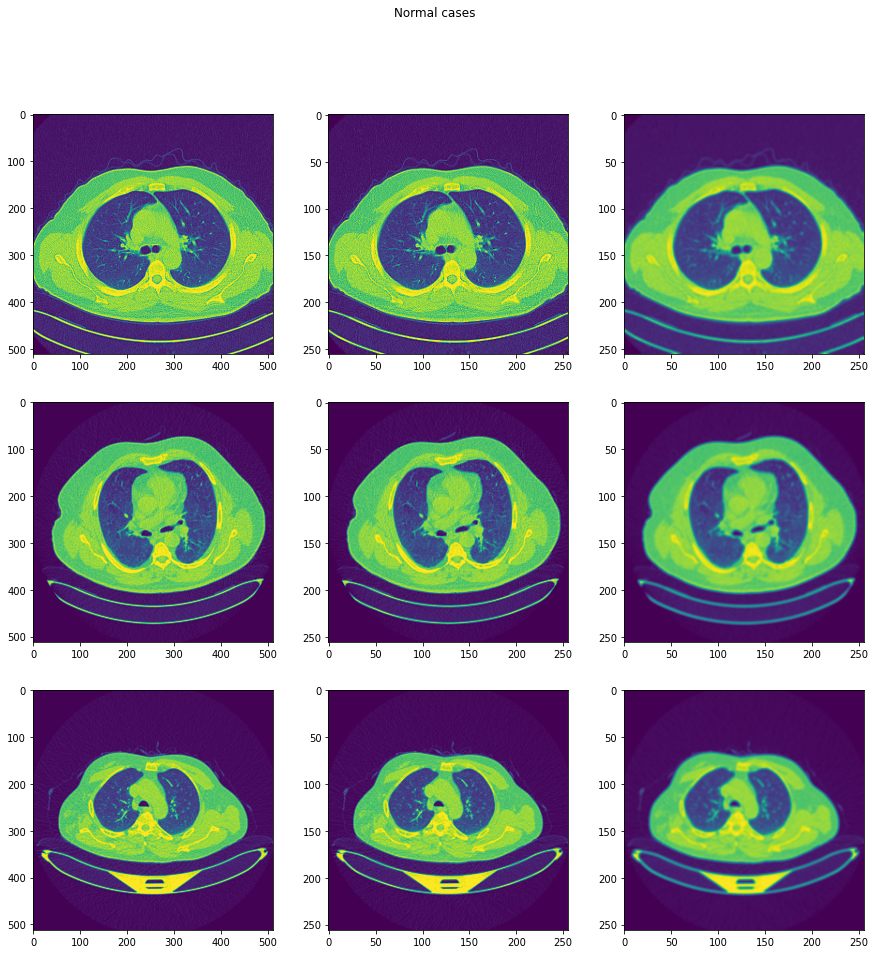

In [ ]:
img_size = 256
for i in categories:
    cnt, samples = 0, 3
    fig, ax = plt.subplots(samples, 3, figsize=(15, 15))
    fig.suptitle(i)

    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for curr_cnt, file in enumerate(os.listdir(path)):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0)

        img0 = cv2.resize(img, (img_size, img_size))

        img1 = cv2.GaussianBlur(img0, (5, 5), 0)

        ax[cnt, 0].imshow(img)
        ax[cnt, 1].imshow(img0)
        ax[cnt, 2].imshow(img1)
        cnt += 1
        if cnt == samples:
            break

plt.show()

# **Preparing Data**

In [ ]:
data = []
img_size = 256

for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0)
        # preprocess here
        img = cv2.resize(img, (img_size, img_size))
        data.append([img, class_num])

random.shuffle(data)

X, y = [], []
for feature, label in data:
    X.append(feature)
    y.append(label)

print('X length:', len(X))
print('y counts:', Counter(y))

# normalize
X = np.array(X).reshape(-1, img_size, img_size, 1)
X = X / 255.0
y = np.array(y)

X length: 1097
y counts: Counter({1: 561, 2: 416, 0: 120})


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=10, stratify=y)

print(len(X_train), X_train.shape)
print(len(X_valid), X_valid.shape)

822 (822, 256, 256, 1)
275 (275, 256, 256, 1)


# **Applying SMOTE to oversample the data**

In [ ]:
print(Counter(y_train), Counter(y_valid))

Counter({1: 420, 2: 312, 0: 90}) Counter({1: 141, 2: 104, 0: 30})


In [ ]:
print(len(X_train), X_train.shape)

X_train = X_train.reshape(X_train.shape[0], img_size*img_size*1)

print(len(X_train), X_train.shape)

822 (822, 256, 256, 1)
822 (822, 65536)


In [ ]:
print('Before SMOTE:', Counter(y_train))
smote = SMOTE()
X_train_sampled, y_train_sampled = smote.fit_resample(X_train, y_train)
print('After SMOTE:', Counter(y_train_sampled))

Before SMOTE: Counter({1: 420, 2: 312, 0: 90})
After SMOTE: Counter({2: 420, 1: 420, 0: 420})


In [ ]:
X_train = X_train.reshape(X_train.shape[0], img_size, img_size, 1)
X_train_sampled = X_train_sampled.reshape(X_train_sampled.shape[0], img_size, img_size, 1)

print(len(X_train), X_train.shape)
print(len(X_train_sampled), X_train_sampled.shape)

822 (822, 256, 256, 1)
1260 (1260, 256, 256, 1)


# **Model Building with SMOTE data**

In [ ]:
model1 = Sequential()

model1.add(Conv2D(64, (3, 3), input_shape=X_train.shape[1:]))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Flatten())
model1.add(Dense(16))
model1.add(Dense(3, activation='softmax'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      640       
                                                                 
 activation (Activation)     (None, 254, 254, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 246016)            0

In [ ]:
model1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model1.fit(X_train_sampled, y_train_sampled, batch_size=8, epochs=3, validation_data=(X_valid, y_valid))

Epoch 1/3
158/158 [==============================] - 202s 1s/step - loss: 0.5449 - accuracy: 0.8492 - val_loss: 0.2439 - val_accuracy: 0.9455
Epoch 2/3
158/158 [==============================] - 194s 1s/step - loss: 0.0214 - accuracy: 0.9968 - val_loss: 0.0573 - val_accuracy: 0.9855
Epoch 3/3
158/158 [==============================] - 198s 1s/step - loss: 7.8783e-04 - accuracy: 1.0000 - val_loss: 0.1269 - val_accuracy: 0.9855


# **Results**

In [ ]:
y_pred = model1.predict(X_valid, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_bool))

print(confusion_matrix(y_true=y_valid, y_pred=y_pred_bool))

9/9 [==============================] - 10s 1s/step
              precision    recall  f1-score   support

           0       1.00      0.87      0.93        30
           1       1.00      1.00      1.00       141
           2       0.96      1.00      0.98       104

    accuracy                           0.99       275
   macro avg       0.99      0.96      0.97       275
weighted avg       0.99      0.99      0.99       275

[[ 26   0   4]
 [  0 141   0]
 [  0   0 104]]


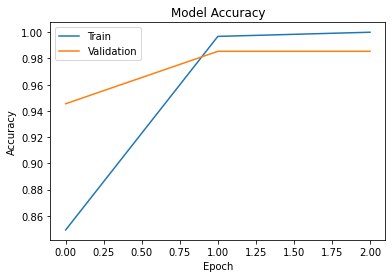

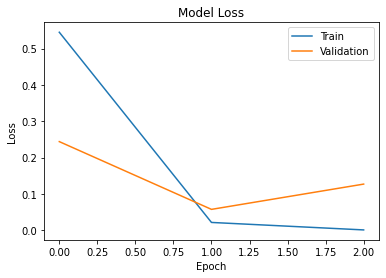

In [ ]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

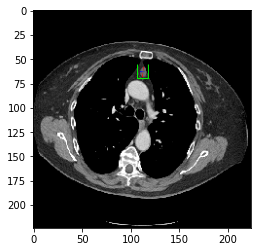

<bound method Model.predict of <keras.engine.sequential.Sequential object at 0x7f7a499bba90>>

In [ ]:
path = "/content/Test cases/000001_03_01_088.png"
img = load_img(path, target_size = (224,224))
input_arr = img_to_array(img)/255

plt.imshow(input_arr)
plt.show()

input_arr.shape

input_arr = np.expand_dims(input_arr, axis = 0)

#pred = model1.predict_classes(input_arr)[0][0][0]
pred = model1.predict
np.argmax(pred)
pred


# **Model Building with Class Weighted Approach**

In [ ]:
model2 = Sequential()

model2.add(Conv2D(64, (3, 3), input_shape=X_train.shape[1:]))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Flatten())
model2.add(Dense(16))
model2.add(Dense(3, activation='softmax'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 254, 254, 64)      640       
                                                                 
 activation_1 (Activation)   (None, 254, 254, 64)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 127, 127, 64)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 64)      36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 246016)           

In [ ]:
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
new_weights = {
    0: X_train.shape[0]/(3*Counter(y_train)[0]),
    1: X_train.shape[0]/(3*Counter(y_train)[1]),
    2: X_train.shape[0]/(3*Counter(y_train)[2]),
}

# new_weights[0] = 0.5
# new_weights[1] = 20

new_weights

{0: 3.0444444444444443, 1: 0.6523809523809524, 2: 0.8782051282051282}

In [ ]:
history = model2.fit(X_train, y_train, batch_size=8, epochs=3, validation_data=(X_valid, y_valid), class_weight=new_weights)

Epoch 1/3
103/103 [==============================] - 153s 1s/step - loss: 1.1321 - accuracy: 0.7032 - val_loss: 0.2368 - val_accuracy: 0.9273
Epoch 2/3
103/103 [==============================] - 135s 1s/step - loss: 0.1047 - accuracy: 0.9720 - val_loss: 0.0655 - val_accuracy: 0.9855
Epoch 3/3
103/103 [==============================] - 131s 1s/step - loss: 0.0661 - accuracy: 0.9891 - val_loss: 0.0488 - val_accuracy: 0.9818


# **Results**

In [ ]:
y_pred = model2.predict(X_valid, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_bool))

print(confusion_matrix(y_true=y_valid, y_pred=y_pred_bool))

9/9 [==============================] - 9s 1s/step
              precision    recall  f1-score   support

           0       0.96      0.87      0.91        30
           1       1.00      1.00      1.00       141
           2       0.96      0.99      0.98       104

    accuracy                           0.98       275
   macro avg       0.98      0.95      0.96       275
weighted avg       0.98      0.98      0.98       275

[[ 26   0   4]
 [  0 141   0]
 [  1   0 103]]


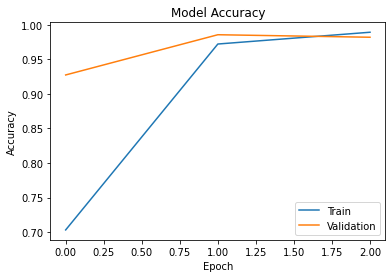

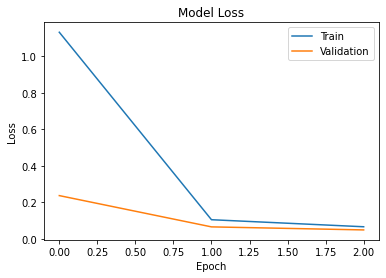

In [ ]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

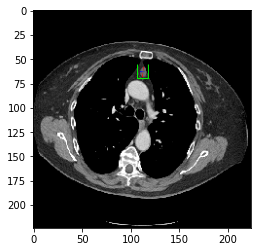

<bound method Model.predict of <keras.engine.sequential.Sequential object at 0x7f7a42c05c50>>

In [ ]:
path = "/content/Test cases/000001_03_01_088.png"
img = load_img(path, target_size = (224,224))
input_arr = img_to_array(img)/255

plt.imshow(input_arr)
plt.show()

input_arr.shape

input_arr = np.expand_dims(input_arr, axis = 0)

#pred = model2.predict_classes(input_arr)[0][0][0]
pred = model2.predict
np.argmax(pred)
pred


# **Data Augmentation**

In [ ]:
train_datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
val_datagen = ImageDataGenerator()

In [ ]:
train_generator = train_datagen.flow(X_train, y_train, batch_size=8)
val_generator = val_datagen.flow(X_valid, y_valid, batch_size=8)

In [ ]:
model3 = Sequential()

model3.add(Conv2D(64, (3, 3), input_shape=X_train.shape[1:]))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Flatten())
model3.add(Dense(16))
model3.add(Dense(3, activation='softmax'))

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 254, 254, 64)      640       
                                                                 
 activation_2 (Activation)   (None, 254, 254, 64)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 127, 127, 64)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 125, 125, 64)      36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 246016)           

In [ ]:
model3.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model3.fit_generator(train_generator, epochs=5, validation_data=val_generator, class_weight=new_weights)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


103/103 [==============================] - 130s 1s/step - loss: 1.0760 - accuracy: 0.5803 - val_loss: 0.8457 - val_accuracy: 0.6036
Epoch 2/5
103/103 [==============================] - 129s 1s/step - loss: 0.5835 - accuracy: 0.7591 - val_loss: 0.3643 - val_accuracy: 0.8327
Epoch 3/5
103/103 [==============================] - 132s 1s/step - loss: 0.3751 - accuracy: 0.8698 - val_loss: 0.2979 - val_accuracy: 0.8873
Epoch 4/5
103/103 [==============================] - 131s 1s/step - loss: 0.2743 - accuracy: 0.9063 - val_loss: 0.2692 - val_accuracy: 0.8982
Epoch 5/5
103/103 [==============================] - 131s 1s/step - loss: 0.1573 - accuracy: 0.9465 - val_loss: 0.1845 - val_accuracy: 0.9273


In [ ]:
y_pred = model3.predict(X_valid, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_bool))

print(confusion_matrix(y_true=y_valid, y_pred=y_pred_bool))

9/9 [==============================] - 10s 1s/step
              precision    recall  f1-score   support

           0       0.81      0.73      0.77        30
           1       0.97      0.97      0.97       141
           2       0.90      0.92      0.91       104

    accuracy                           0.93       275
   macro avg       0.89      0.88      0.88       275
weighted avg       0.93      0.93      0.93       275

[[ 22   1   7]
 [  0 137   4]
 [  5   3  96]]


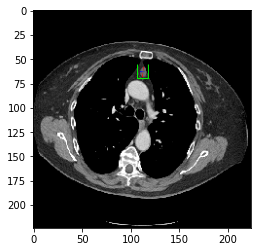

<bound method Model.predict of <keras.engine.sequential.Sequential object at 0x7f7a3e6a16d0>>

In [ ]:
path = "/content/Test cases/000001_03_01_088.png"
img = load_img(path, target_size = (224,224))
input_arr = img_to_array(img)/255

plt.imshow(input_arr)
plt.show()

input_arr.shape

input_arr = np.expand_dims(input_arr, axis = 0)

#pred = model3.predict_classes(input_arr)[0][0][0]
pred = model3.predict
np.argmax(pred)
pred
